# Table of Contents
1. [Introduction](#Introduction)
2. [Setup and Initialization](#Setup-and-Initialization)
3. [Completeness](#Completeness)
4. [Trends](#Trends)
   * [Hourly Trends](#Hourly-Trends)
   * [Daily Trends](#Daily-Trends)
   * [Annual Trends](#Annual-Trends)
   * [Decennial Trends](#Decennial-Trends)
5. [Analysis](#Analysis)
   * [The Friday Problems](#The-Friday-Problems)
   * [Bimodality](#Bimodality)

<a id='intro'></a>
# Introduction
This notebook is an exploration of time-based trends seen in [1.6 million UK traffic accidents][1] dataset. 

We would like to note that the various forms of the dataset has been upload to kaggle multiple times, including

|dataset|kaggler|
|---|---|
|[1.6 million UK traffic accidents][1]|[Dave Fisher-Hickey][2]|
|[UK Car Accidents 2005-2015][3]|[Silicon99][4]|
|[UK Road Safety: Traffic Accidents and Vehicles][5]|[Thanasis][6]|
|[UK Accidents 10 years history with many variables][7]|[Ben Fedit][8]|
|[Road Accident (United Kingdom (UK)) Dataset][9]|[Dev Ansodariya][10]|

The original dataset has 33 features describing each of the accidents recorded therein, where the attributes included describe things like
* the date and time of the accident
* the physical location of the accident
* the current weather conditions
* the severity of the accident

Here, we are going to focus simply on the date and time features, of which there are the following four

|feature|description|
|---|---|
|Date|formatted as DD/MM/YYYY|
|Time|formatted as HH:MM|
|Year|YYYY|
|Day_of_Week|1=Sun, 2=Mon, 3=Tue, 4=Wed, 5=Thu, 6=Fri, 7=Sat|


[1]:https://www.kaggle.com/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales/data
[2]:https://www.kaggle.com/daveianhickey
[3]:https://www.kaggle.com/datasets/silicon99/dft-accident-data
[4]:https://www.kaggle.com/silicon99
[5]:https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles
[6]:https://www.kaggle.com/tsiaras
[7]:https://www.kaggle.com/datasets/benoit72/uk-accidents-10-years-history-with-many-variables
[8]:https://www.kaggle.com/benoit72
[9]:https://www.kaggle.com/datasets/devansodariya/road-accident-united-kingdom-uk-dataset
[10]:https://www.kaggle.com/devansodariya

# Setup and Initialization
Load the dataset and import the necessary modules.

We do need to note that the numbering convention used in the dataset for identifying the `Day_of_Week` differs from the python convention. In python, 
* the week runs from Monday thru Sunday
* the weekday numbers from 0 to 6
* Monday=0, Tuesday=1, ..., Sunday=6

In the dataset, however, 
* the week runs from Sunday thru Saturday
* the weekday numbers from from 1 to 7
* Sunday=1, Monday=2, ..., Saturday=7

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()

columns = [
    'Date',
    'Time',
    'Year',
    'Day_of_Week'
    ]

DATAFILES = [
    '/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2005_to_2007.csv',
    '/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2009_to_2011.csv',
    '/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv'
    ]

df_accidents = pd.concat([pd.read_csv(f, low_memory=False) for f in DATAFILES])[columns].dropna()
DAY_NAME = dict( zip(range(1,8),['Sun','Mon','Tue','Wed','Thu','Fri','Sat']))

fmt = '%d/%m/%Y %H:%M'
df_accidents['datetime'] = pd.to_datetime( df_accidents.Date + " " + df_accidents.Time, format=fmt)

# Completeness
The first question to look at is the completeness of the data.  Does the dataset contain records covering every day over the time range, or are there missing days? An easy way to investigate this is to simply count the number of unique days per year found in the dataset.

In [2]:
df_accidents.groupby('Year').Date.nunique()

Year
2005    365
2006    365
2007    365
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
Name: Date, dtype: int64

There are several things to notice here:
1. The dataset covers the date range 2005-2014
2. This date range includes two leap years - 2008 and 2012
3. There are no records for the `Year=2008`; this year is simply missing.
3. For the years represented, the dataset does indeed have 365 days in a normal year and 366 in the leap year

As such, the daily coverage is complete, once we overlook the one missing year 2008.

# Trends
Next, we would like to look at the data on various timescales. Our goal here is simply to survey the phenomena.  We will defer analysis of the observed phenomena to the the section. 

## Hourly Trends
We will start by looking at the trends throughout the day, and exploring how the frequency of accidents depends upon the time of day.  We suspect that the trends will depend somewhat upon the day of the week; at a bare minimum, we would expected a difference in behavior to show up between weekdays and weekends. As such, we will break out the analysis of the hourly trends on a per `Day_of_Week` basis.

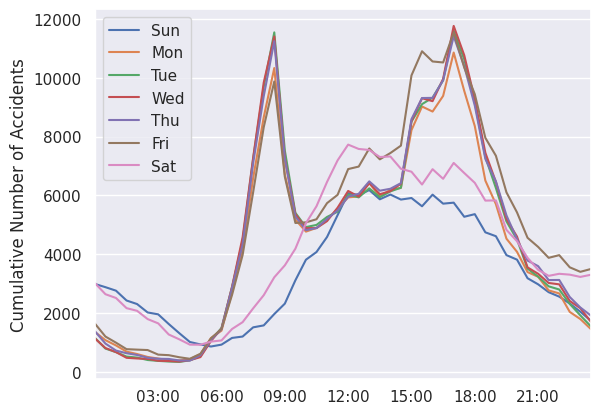

In [3]:
fig, ax = plt.subplots(facecolor='white')
for day, group in df_accidents.groupby('Day_of_Week'):
    _ = group.groupby('Time', as_index=False).size()
    _ = _.set_index( pd.to_datetime( _.Time, format="%H:%M")).drop(columns='Time')
    _.resample('30min').sum().plot(ax=ax,  y='size', label=DAY_NAME[day])
ax.set_xticklabels("")
ax.set_xlabel(None)
ax.set_ylabel("Cumulative Number of Accidents");

This is a bit more interesting than we were suspecting.  

Monday thru Thursday looks to be fairly straightforward, with all four days being basically the same. Things are very quiet until roughly 6AM, when the morning commute begins. The number of accidents rise rapidly, maxing out at the peak of the morning rush hour (roughly 8:30AM). Things fall off a bit during the middle of the workday, and then peak again during the evening rush hour.

Friday morning starts off the same as the other weekdays, showing the max during the peak of the morning rush hour. Then, something starts to happen mid-morning; there is a noticeable increase in accidents, well above the rate seen on a normal weekend, that continues throughout the afternoon. Oddly enough, the "evening rushhour peak" is unaffected by whatever is responsible for the surplus of accidents on Friday afternoon. However, once rush hour has passed, the surplus reappears and continues through the rest of the evening. The weekends naturally do not suffer from the rush hour peaks.  There is, however, a substantial increase in the number of accidents in the early mornings (midnight to 5AM) on both Saturday and Sunday.  As such, in our mind there are two oddities here that merit further investigation
1. The Friday afternoon bump in accidents
2. The post-midnight surpluss seen on both Friday and Saturday night

## Daily Trends
Next, let's look at how the total number of accidents per day varies throughout the week. 

Initially, we were tempted to simply count the number of accidents per day and present that as a bar plot. Then, we realized that this was almost an ideal problem for employing a [violin plot][1], which would allow us to display both
* the relative number of accident between the days
* the distribution of accidents on each of the days

*NOTE: in the graph below, we have added an annotation above each violin to display the show the mean value of accidents for the day.*

[1]:https://en.wikipedia.org/wiki/Violin_plot

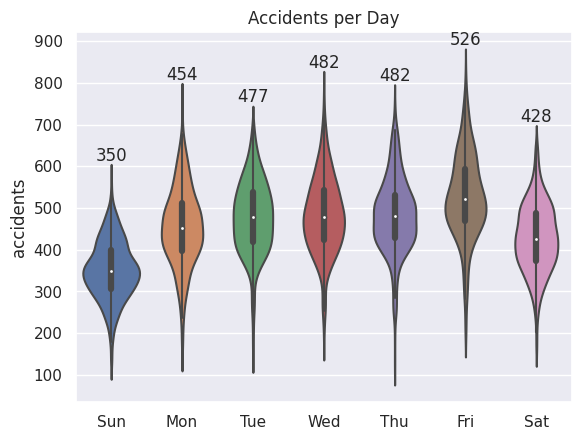

In [4]:
from matplotlib.collections import PolyCollection

_ = df_accidents.groupby(['Date','Day_of_Week']).\
    size().\
    to_frame(name='accidents').\
    reset_index().\
    drop(columns='Date')
_['Day'] = _.Day_of_Week.map(DAY_NAME)
order = [DAY_NAME[x] for x in sorted(DAY_NAME)]
ax = sns.violinplot(data=_, x='Day', y='accidents', order=order)
ax.set_xlabel(None);

daily_mean = _.groupby('Day_of_Week').accidents.mean().to_dict()
num = 0
for i, violin in enumerate(ax.collections):
    if type(violin) != PolyCollection:
        continue
    num += 1
    x_pos = violin.get_paths()[0].vertices[:, 0].mean()
    y_pos = violin.get_paths()[0].vertices[:, 1].max()
    label = int( daily_mean[num] )
    plt.text(x_pos, y_pos, label, ha="center", va="bottom")

ax.set_title("Accidents per Day");

The following observations can be gleaned from this plot
1. Accidents grow during the work week, peaking on Friday
2. Accidents decrease significantly on the weekend, bottoming out on Sunday
3. ***Friday suffers from 50% more accidents than Sunday***
4. There is an unusual bimodality affecting the weekend distributions
5. Friday and possibly Thursday are also showing hints of bimodality

Of these observations, we were most surprised by the bimodality - the data apparently shows two different patterns of weekend driving. This seems like it merits further investigation, but our kneejerk is to guess that this may be a seasonal variation, with people being more likely to enjoy weekend trips in the summertime when the weather is good and the kids are out of school, while staying closer to home in the winter.

## Annual Trends
Next, we would like to look at the trends throughout the year.  As here was are concerned with the longer term trends in accidents and ***not*** in the large intraweek variations discussed above, we will simply sum the accidents on weekly basis. Personally, we do not naturally think of dates in terms of "week number". To help make things a bit more intuitive, we will also annotate the numbers with the quarter of the year the week falls into, where
* Q1 = Jan-Mar
* Q2 = Apr-Jun
* Q3 = Jul-Sep
* Q4 = Oct-Dec

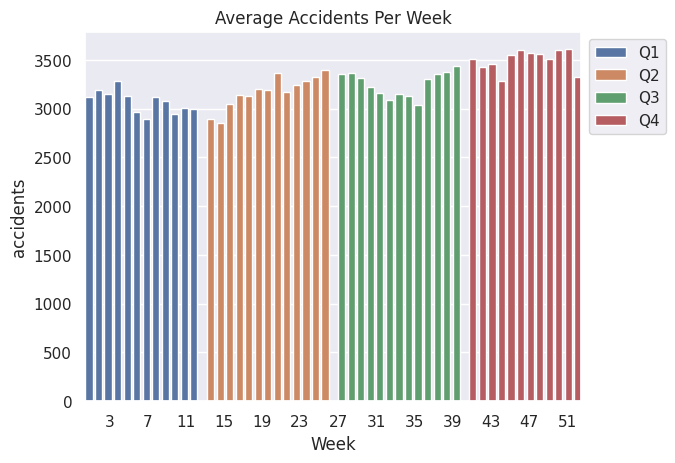

In [5]:
non_leap_year = df_accidents.query('Year != "2012"')
n_years = non_leap_year.Year.nunique()
week = (pd.to_datetime( non_leap_year.Date, format="%d/%m/%Y").dt.day_of_year - 1)//7 + 1
week.name = 'Week'

df_perweek = week[week<53].value_counts().sort_index().to_frame(name='accidents').reset_index()
df_perweek.accidents = df_perweek.accidents / n_years
df_perweek['quarter'] = "Q" + ((df_perweek.Week-1) // 13 + 1).astype('str')

ax = sns.barplot(data=df_perweek, x='Week', y='accidents', hue='quarter', width=3)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.xaxis.set_ticks( range(2,54,4))
ax.set_title("Average Accidents Per Week");

We gleaned the following observations from the above plot
1. Overall, there is a linear growth in number of accidents per week throughout the year
2. Holidays are marked with a ***lower*** rate of accidents
   * there is a slight decrease in during the February school break
   * there is also a slight decrease during the two week Easter Holiday
   * there is a larger decrease during August, a traditional time for vacation
   * there is a ***huge*** decrease during the Christmas holidays

## Decennial Trends
We are finally ready to look at the dataset at the largest timescale - the full decade over which the data was gather. We do like the format of tracking the total number of accidents per week.  However, rather than averaging over the dataset the number of accidents that happened in the $x^{th}$ week of a given year, we will simply look at a running weekly total of the accidents.

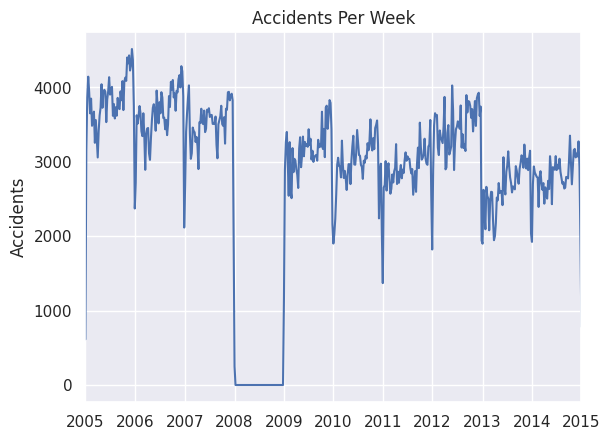

In [6]:
_ = pd.DataFrame(
    index=pd.to_datetime( df_accidents.Date, format='%d/%m/%Y'),
    data={'accidents' : 1}
).resample( rule='1W').sum().reset_index()
ax = _.plot(x='Date', y='accidents', legend=False)
ax.set_xlabel(None)
ax.set_ylabel("Accidents")
ax.set_title("Accidents Per Week");

Honestly, to us this graph looks to be absurd.  Roughly speaking, it is saying
* During each year, the number of accidents per week increases linearly throughout the year
* However, there is typically a [step-function][1] decrease on a year-by-year basis
* For some bizarre reason, that step function didn't occur in 2012 - rather, the accidents in 2012 continued the linear rise from 2011
* Oddly enough, though, it looks like a ***double step*** kicked in between 2012 and 2013 (as if the missing step from 2012 magically reappeared)

That simply strains credulity.  It is far easier for us to believe these detailed trends reflect either problems with or changes in the data collection process. 

[1]:https://en.wikipedia.org/wiki/Heaviside_step_function

# Analysis

## The Friday Problems
when we examined the hourly trends, we noted two separate anomalies that we here call ***the Friday Problems***
1. An uptick in afternoon accidents, relative to the other weekdays
2. An uptick in late-night (11PM-5AM) accidents occuring on both Friday and Saturday nights

Offhand, two separate hypotheses came to mind as possible explanations for these oddities
* [British Pub Culture][1]
* Weekend Travel/Long Weekends

To us, the long weekend hypothesis seems like it could contribute to the Friday afternoon accidents (people leaving work early to travel to their destination), but we would find it unlikely to be the source of the excess in late night accidents.  Pub culture, however, seems a reasonable hypothesis for the late night accidents but ***not*** for the afternoon spike - as the afternoon increase rears its head far too early in the day (late morning!) to be blamed on drivers having downed a few after work.

What test could we run on a time series to shed some light on these hypotheses? We would expect the long weekend hypothesis to exhibit seasonality - a greater willingness to take a weekend jaunt during the warm summer than in the cold winter - while pub culture has no season. This suggests the following approach
1. Define a time block of interest - e.g., noon-4PM
2. Count the number of accidents that occur in that time block
3. Assume that one day (Friday) is anomalous while the prior day (Thursday) looks to be representative
4. Compare the count from anomalous afternoon to that the day before - define this to be ***the excess***
5. Calculate this excess over a multi-year period
6. Examine this excess over time to look for evidence of periodicity

A similar approach would be taken to look at the late night accidents, comparing late night Friday to late night Thursday.

[1]:https://greatbritishmag.co.uk/uk-culture/british-pub-culture/

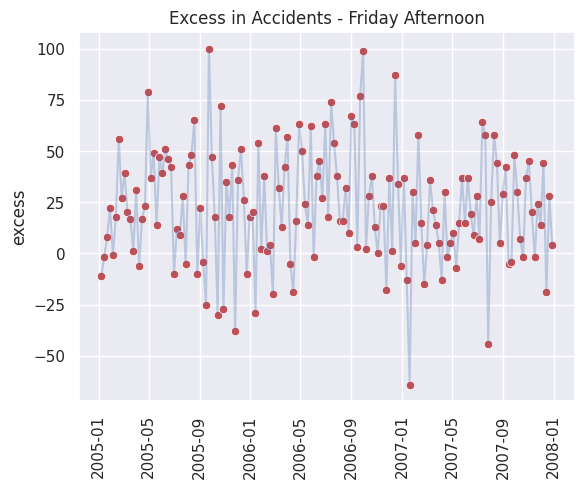

In [7]:
def excess( df, days=1):
    '''
    First counts the number of accidents per day, and then
    calculates the difference in that number between two dates
    that are X days apart.
    '''

    # Start off by simply counting the number of accidents per day
    df = df.groupby('Date').apply(len, include_groups=False).to_frame(name='accidents').reset_index()

    # Next, sort the data by date, in anticipation of differencing
    df.Date = pd.to_datetime(df.Date, format="%d/%m/%Y")
    df = df.sort_values(by='Date').reset_index(drop=True)
    df['Day'] = df.Date.dt.strftime("%a")

    # Finally, calculate the difference between two neighboring dates
    df['excess'] = df.accidents - df.accidents.shift(days)
    df = df.dropna().reset_index(drop=True)
    df.excess = df.excess.astype('int64')
    
    return df.reset_index(drop=True)

def display_excess( df, day, title):   
    _ = df.query(f"Day=='{day}'")
    sns.lineplot(data=_, x='Date', y='excess', alpha=0.3)
    sns.scatterplot(data=_, x='Date', y='excess', c='r')
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.title(title);

afternoon = 'Year < 2008 and "12:00" <= Time <= "16:00"'
_ = excess( df_accidents.query(afternoon) )
display_excess( _, 'Fri', "Excess in Accidents - Friday Afternoon")

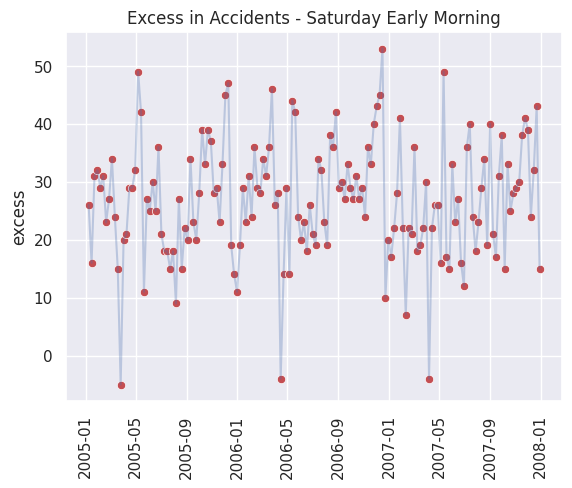

In [8]:
latenight = 'Year < 2008 and "00:00" <= Time <= "04:00"'
_ = excess( df_accidents.query(latenight) )
display_excess( _, 'Sat', "Excess in Accidents - Saturday Early Morning")

From these graphs we can detect no evidence of an annual seasonality with the Friday afternoon accidents nor the late night Friday/early morning Saturday accidents. The is a hint of a cycle in the Friday afternoon accidents - with a peak in mid-summer 2006 and then dropping until mid-summer 2007 - but certainly no annual seasonality.

This does not rule out travel for long weekends as significantly contributing to the Friday afternoon excess.  Instead, it could simply be saying that our assumption about a seasonality to with long weekends is simply wrong.

## Bimodality
When we looked above at the [daily trends](#Daily-Trends), we noted a bimodality in the violin plots that was especially prominent on Sunday. Our natural inclination would be to wonder if this was a summer/winter thing, where people were more likely to be out and about during the weekends of summer than those of winter. Nonetheless, a natural place to being the investigation is simply examine the Sunday accidents throughout the time range covered by the dataset, and to compare those results to a day which lacked the bimodality.  

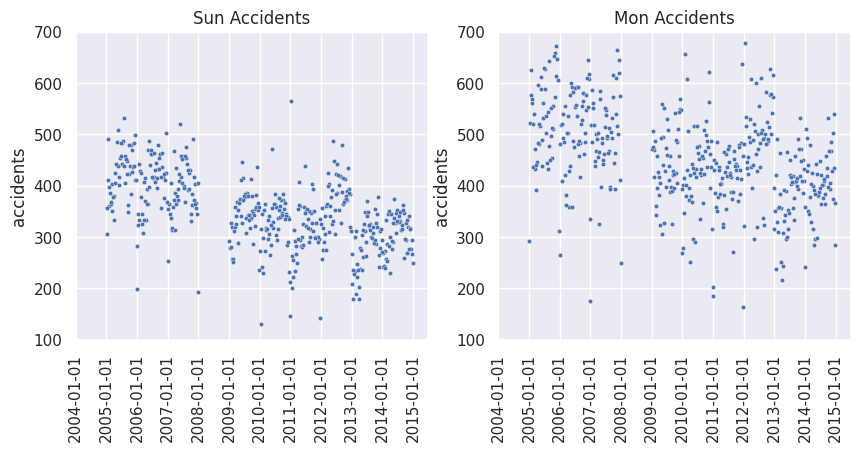

In [9]:
def daily_accidents(ax, df, day_of_week):

    _ = df.groupby(['Date','Day_of_Week']).\
        size().\
        to_frame(name='accidents').\
        reset_index().\
        query(f'Day_of_Week=={day_of_week}')
    _.Date = pd.to_datetime(_.Date, format='%d/%m/%Y')
    
    sns.scatterplot(ax=ax, data=_, x='Date',  y='accidents', s=10)
    ax.set_title(f"{DAY_NAME[day_of_week]} Accidents")
    ax.xaxis.set_ticks( ax.get_xticks())
    ax.xaxis.set_ticklabels( ax.xaxis.get_ticklabels(), rotation=90)
    ax.set_ylim(100,700)
    ax.set_xlabel(None)

fig, axes = plt.subplots( 1,2,figsize=(10,4))
daily_accidents( axes[0], df_accidents, 1 )
daily_accidents( axes[1], df_accidents, 2 )

These graphs seem to rule out winter/summer as the source of the Sunday bimodality. ***Rather, it is the missing year!***  Let us explain.

Both the Sunday and Monday accidents show a downward trend over the decade covered by the dataset. Within a given year, there is a fair amount of variance in the number of accidents and a week-to-week basis, but there is an overall downward trend.  With the Monday accidents, the variance (the scatter about the trend) is fairly broad - so much so that the numbers for Mondays in 2009 are not too dissimilar to those from 2007.  With the Sunday accidents, however, the variance is much smaller.  So much so that the accidents a from 2009-2015 (if exclude those from 2012) look to be from a different population than those from prior to 2008.  If the data from 2008 were ***not*** missing, it looks like it would have blurred the two "populations" together and the bimodality would not have been visible.